In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
from scipy.ndimage import gaussian_filter

# ============================================================
# 1. ENHANCED HARMONIC GENERATOR (CONUS GRID, GLOBAL MAPPING)
# ============================================================
def smooth_field(n=200, lmax=20, decay_power=2.5, seed=1):

    rng = np.random.default_rng(seed)

    # --- CONUS grid (actual output grid) ---
    lat = np.deg2rad(np.linspace(25, 49, n))
    lon = np.deg2rad(np.linspace(-125, -66, n))
    Lon, Lat = np.meshgrid(lon, lat)

    # --- map CONUS grid to full sphere coordinates ---
    phi = (Lon - lon.min()) / (lon.max() - lon.min()) * (2*np.pi) - np.pi
    Lat_global = (Lat - lat.min()) / (lat.max() - lat.min()) * np.pi - np.pi/2
    theta = np.pi/2 - Lat_global

    f = np.zeros_like(theta, dtype=complex)

    for l in range(1, lmax+1):
        amp = 1/(1+l)**decay_power
        for m in range(-l, l+1):
            coeff = amp*(rng.normal() + 1j*rng.normal())
            f += coeff * sph_harm(m, l, phi, theta)

    f = np.real(f)

    return Lat, Lon, (f - f.mean()) / f.std()

# Base Field (Large scale structures)
Lat, Lon, psi_base = smooth_field(lmax=15, decay_power=2.0, seed=1)

# Turbulent Layer (High-frequency "crunch")
_, _, psi_turb = smooth_field(lmax=60, decay_power=1.2, seed=42)

# ============================================================
# 2. LAND MASK & COASTAL ROUGHNESS
# ============================================================
lat_deg, lon_deg = np.rad2deg(Lat), np.rad2deg(Lon)
land = ((np.abs(lon_deg + 60) < 35) & (lat_deg > -10) & (lat_deg < 60)) | \
       ((np.abs(lon_deg - 20) < 45) & (lat_deg > -35) & (lat_deg < 70)) | \
       ((np.abs(lon_deg - 110) < 35) & (lat_deg > -10) & (lat_deg < 55))

land_smooth = gaussian_filter(land.astype(float), sigma=8, mode="wrap")

# Calculate Coastline Gradients to inject local noise
dM_dlat, dM_dlon = np.gradient(land_smooth)
coast_roughness = np.sqrt(dM_dlat**2 + dM_dlon**2)

# ============================================================
# 3. SELECTIVE BLENDING (Physical Biasing)
# ============================================================
# Storm Tracks: Turbulence is strongest in mid-latitudes (approx 45°)
storm_track_envelope = np.exp(-(np.abs(Lat) - np.deg2rad(45))**2 / 0.15)

# Background flow (Zonal Bands)
# A sin(Lat) derivative will produce negative u (East-to-West) at the equator.
# We use 1.5 * cos(Lat) as the streamfunction contribution.
trade_wind_strength = 2.0 
psi_trades = trade_wind_strength * np.sin(Lat) 

# 3. Combine them (Note: we add psi_trades here)
psi_physical = (psi_base * 0.8) + \
               (psi_trades) + \
               (psi_turb * 0.3 * storm_track_envelope)

# Inject "Coastal Jitter" directly into the field to break IDW interpolation
rng = np.random.default_rng(7)
psi_physical += rng.normal(0, 0.08, Lat.shape) * coast_roughness




# ============================================================
# 4. COMPUTE WIND (Rotational + Small Divergent component)
# ============================================================
dlat = Lat[1,0] - Lat[0,0]
dlon = Lon[0,1] - Lon[0,0]
coslat_safe = np.clip(np.cos(Lat), 0.1, 1.0)

# Rotational component (Primary flow)
dpsi_dlat, dpsi_dlon = np.gradient(psi_physical, dlat, dlon)
u_rot = -dpsi_dlat
v_rot = dpsi_dlon / coslat_safe

# Divergent component (Small "leakage" to break streamfunction perfection)
# This makes vectors point slightly 'inward' or 'outward' of cells
dphi_dlat, dphi_dlon = np.gradient(psi_physical * 0.05, dlat, dlon)
convergence_strength = 0.2
u_div = 0 # Keep zonal divergence neutral
v_div = -convergence_strength * np.sin(Lat) # Pulls North air South, and South air North

# Merge and apply friction
u = (u_rot + u_div) * (1.0 - 0.4 * land_smooth)
v = (v_rot + v_div) * (1.0 - 0.4 * land_smooth)

speed = np.sqrt(u**2 + v**2)


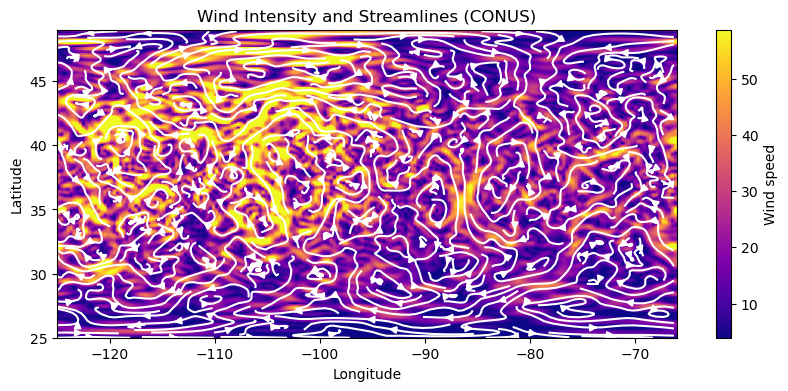

In [2]:
lat_deg = np.rad2deg(Lat)
lon_deg = np.rad2deg(Lon)

plt.figure(figsize=(10,4))

im = plt.imshow(
    speed,
    origin="lower",
    extent=[lon_deg.min(), lon_deg.max(), lat_deg.min(), lat_deg.max()],
    aspect="auto",
    cmap="plasma",
    vmin=np.percentile(speed,5),
    vmax=np.percentile(speed,95),
)

step = 3
plt.streamplot(
    lon_deg[0, ::step],          # x grid (1D, increasing)
    lat_deg[::step, 0],          # y grid (1D, increasing)
    u[::step, ::step],
    v[::step, ::step],
    color="white",
    density=2,
)

# optional coastline-ish contour from your mask (now regional)
# plt.contour(lon_deg, lat_deg, land_smooth, levels=[0.5], colors="white", linewidths=1.0)

plt.colorbar(im, label="Wind speed")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.xlim(lon_deg.min(), lon_deg.max())
plt.ylim(lat_deg.min(), lat_deg.max())

plt.title("Wind Intensity and Streamlines (CONUS)")
plt.show()

In [3]:
np.savez("wind_data.npz", lon=lon_deg, lat=lat_deg, u=u, v=v, speed=speed)